In [1]:
from tensorflow.python.summary.summary_iterator import summary_iterator
import glob
import os
import tensorboard as tb
import glob
import os
import pprint
import traceback
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import click
import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
from tqdm import tqdm as tqdm
from plottify import autosize
from matplotlib.colors import ListedColormap

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set()

hereon_color_array = np.array([
         [230, 0, 70],
    [0,145,160],

    [0, 170, 230],
   
    
    [250,180,35],
    [0,70,125],
    [175, 25, 60],
    [170, 200 ,70],
    [250,115,80],
    [140, 90, 180],
      
])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)

sns.set_palette(hereon_color_array)

NameError: name 'np' is not defined

In [3]:
hereon_cmap

In [4]:
paths = [
    "/gpfs/work/machnitz/plankton_logs/juwels_results", 
       ]

counter = 0

tf_files = []

for path in paths:
    for current_path, current_sub_dirs, current_files in os.walk(path):
        for file in current_files:
            if "events.out.tfevents" in file:
                tf_files.append(os.path.join(current_path, file))

for file in tf_files:
    print(file, os.path.getsize(file) /(1024*1024))

/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/21-34-44/0/logs/tensorboard/default/all/events.out.tfevents.1642538567.jwb0058.juwels.29177.0 0.008798599243164062
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/22-50-57/0/logs/tensorboard/default/all/events.out.tfevents.1642542839.jwb0858.juwels.8272.0 39.35325527191162
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/22-13-34/0/logs/tensorboard/default/all/events.out.tfevents.1642540525.jwb0006.juwels.25838.0 0.008798599243164062
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/7/logs/tensorboard/default/all/events.out.tfevents.1642533514.jwb0327.juwels.19610.0 35.38253116607666
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/6/logs/tensorboard/default/all/events.out.tfevents.1642533514.jwb0266.juwels.4519.0 35.520484924316406
/gpfs/work/machnitz/plankton_logs/juwels_results/2022-01-18/20-13-49/3/logs/tensorboard/default/all/events.out.tfevents.1642533387.jwb0

In [5]:
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 0,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    UNUSED_TAGS = ["on_train", "Cond. Acc"]
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            if any([(unused_tag in tag) for unused_tag in UNUSED_TAGS]):
                continue
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs

def get_hparams_file_from_tf_file(tf_file):
    hparams_path = os.path.split(tf_file)[0]
    while not any([".hydra" in folder for folder in glob.glob(os.path.join(hparams_path, ".*"))]):
        hparams_path = os.path.split(hparams_path)[0]
        if hparams_path in ["", "/"]:
            hparams_file = ""
            break
    
    hparams_file = os.path.join(hparams_path, ".hydra/config.yaml")

    if os.path.isfile(hparams_file):
        return hparams_file, hparams_path
    else:
        print(f"No hparams file for {tf_file}")
        return None, None
    
def get_hparams_dict(hparams_file):
    with open(hparams_file, "r") as stream:
        content = yaml.safe_load(stream)
    return content

In [6]:
all_series = []
for tf_file in tqdm(tf_files):
    try:
        df_raw = tflog2pandas(tf_file)
        df_pivot = pd.pivot_table(df_raw, columns=["metric"], values=['value'], aggfunc={'value': [min, max, np.argmax]})
        hparams_file, hparams_path = get_hparams_file_from_tf_file(tf_file)
        hparams_dict = get_hparams_dict(hparams_file)
        subsample_size = hparams_dict["datamodule"]["subsample_supervised"]
        feature_extractor = hparams_dict["load_state_dict"]
        mode = "SimCLR" if feature_extractor else "Supervised"
        this_series = df_pivot.iloc[df_pivot["Accuracy/Validation"].argmax()]
        this_series["Accuracy/Validation"] = df_pivot["Accuracy/Validation"]["value"]["max"]
        this_series["Validation Accuracy"] = df_pivot["hp/accuracy"]["value"]["max"]
        this_series["Validation Loss"] = df_pivot["hp/loss"]["value"]["min"]
        this_series["loss/Training"] = df_pivot["loss/Training"]["value"]["min"]
        this_series["loss/Validation"] = df_pivot["loss/Validation"]["value"]["min"]
        this_series["mode"] = mode
        this_series["feature_extractor"] = feature_extractor
        this_series["run_path"] = hparams_path
        this_series["max_acc_index"] = int(df_raw.iloc[int(df_pivot["Accuracy/Validation"]["value"]["argmax"])]["step"])
        this_series["Labels per class"] = hparams_dict["datamodule"]["subsample_supervised"]
        all_series.append(this_series)
    except Exception as e:
        print(e)
        
df = pd.DataFrame(all_series).reset_index().reset_index()
# df = df.reset_index()
del df["index"]

  0%|                                                                                                                                                                                                                                                           | 0/40 [00:00<?, ?it/s]

'Accuracy/Validation'


  5%|████████████▏                                                                                                                                                                                                                                      | 2/40 [00:00<00:07,  4.84it/s]

'Accuracy/Validation'


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 29/40 [00:07<00:03,  3.18it/s]

'Accuracy/Validation'


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 38/40 [00:09<00:00,  6.14it/s]

'Accuracy/Validation'
'Accuracy/Validation'


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:10<00:00,  3.96it/s]

'Accuracy/Validation'


In [7]:
df

metric,level_0,level_1,Accuracy/Training,Accuracy/Validation,Cosine LR,epoch,hp/accuracy,hp/epoch,hp/loss,loss/Training,loss/Validation,Validation Accuracy,Validation Loss,mode,feature_extractor,run_path,max_acc_index,Labels per class
0,value,argmax,1179.000000,0.674211,0.00,1267.0,98.000000,100.0,45.000000,0.165031,2.251476,0.674211,0.0,Supervised,None,/gpfs/work/machnitz/plankton_logs/juwels_resul...,0,8000
1,value,argmax,137.000000,0.766695,0.00,396.0,62.000000,100.0,2.000000,0.036502,2.070256,0.766695,0.0,SimCLR,/p/project/hai_emulator/plankton_data/complete...,/gpfs/work/machnitz/plankton_logs/juwels_resul...,0,500
2,value,argmax,79.000000,0.761945,0.00,336.0,55.000000,100.0,1.000000,0.028384,2.079601,0.761945,0.0,SimCLR,/p/project/hai_emulator/plankton_data/complete...,/gpfs/work/machnitz/plankton_logs/juwels_resul...,0,400
3,value,argmax,26.000000,0.708229,0.00,158.0,27.000000,100.0,1.000000,0.099384,2.137231,0.708229,0.0,SimCLR,/p/project/hai_emulator/plankton_data/complete...,/gpfs/work/machnitz/plankton_logs/juwels_resul...,0,100
4,value,argmax,297.000000,0.810841,0.00,1841.0,91.000000,100.0,1.000000,0.001881,2.035060,0.810841,0.0,SimCLR,/p/project/hai_emulator/plankton_data/complete...,/gpfs/work/machnitz/plankton_logs/juwels_resul...,0,3000
5,value,argmax,123.000000,0.752165,0.00,277.0,62.000000,100.0,1.000000,0.075108,2.092836,0.752165,0.0,SimCLR,/p/project/hai_emulator/plankton_data/complete...,/gpfs/work/machnitz/plankton_logs/juwels_resul...,0,300
6,value,argmax,25.000000,0.637399,0.00,128.0,90.000000,100.0,1.000000,0.162273,2.209961,0.637399,0.0,SimCLR,/p/project/hai_emulator/plankton_data/complete...,/gpfs/work/machnitz/plankton_logs/juwels_resul...,0,50
7,value,argmax,78.000000,0.736239,0.00,217.0,40.000000,100.0,1.000000,0.058073,2.103882,0.736239,0.0,SimCLR,/p/project/hai_emulator/plankton_data/complete...,/gpfs/work/machnitz/plankton_logs/juwels_resul...,0,200
8,value,argmax,10.000000,0.547639,0.00,118.0,57.000000,100.0,1.000000,0.371993,2.296199,0.547639,0.0,SimCLR,/p/project/hai_emulator/plankton_data/complete...,/gpfs/work/machnitz/plankton_logs/juwels_resul...,0,20
9,value,argmax,5.000000,0.450964,0.00,108.0,98.000000,100.0,1.000000,0.314060,2.374772,0.450964,0.0,SimCLR,/p/project/hai_emulator/plankton_data/complete...,/gpfs/work/machnitz/plankton_logs/juwels_resul...,0,10


In [27]:
df_grouped = df.groupby(["Labels per class", "mode"]).max()

/gpfs/home/machnitz/miniconda3/envs/hydra/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


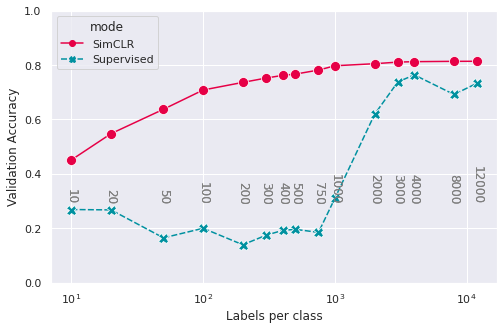

In [9]:
# df = df[df["Labels per class"] <= 3500]  # do not use all runs, because not all is finished yet!
fig, ax = plt.subplots(figsize=(8,5), nrows=1, ncols=1)
sns.lineplot(data=df_grouped, x="Labels per class", y="Validation Accuracy", hue="mode", ax=ax, markers=True, style="mode", markersize=10, palette=hereon_color_array)
# autosize()
ax.set_xscale("log")

ax.set_ylim(0,1)

for item in df_grouped.groupby("Labels per class"):
    #item[1] is a grouped data frame
    for x,y,m in item[1].reset_index()[["Labels per class","Validation Accuracy","Labels per class"]].values:
        ax.text(x,0.3,f'{m:.0f}',color="grey", horizontalalignment="center", rotation=-90)

plt.savefig("simclr_vs_supervised.png", dpi=600)
plt.show()


/gpfs/home/machnitz/miniconda3/envs/hydra/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


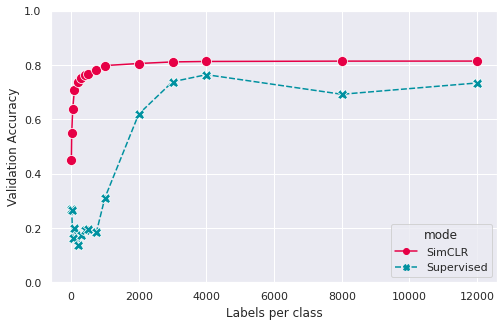

In [10]:
# df = df[df["Labels per class"] <= 3500]  # do not use all runs, because not all is finished yet!
fig, ax = plt.subplots(figsize=(8,5), nrows=1, ncols=1)
sns.lineplot(data=df_grouped, x="Labels per class", y="Validation Accuracy", hue="mode", ax=ax, markers=True, style="mode", markersize=10, palette=hereon_color_array)
# autosize()
# ax.set_xscale("log")

ax.set_ylim(0,1)

# for item in df_grouped.groupby("Labels per class"):
#     #item[1] is a grouped data frame
#     for x,y,m in item[1].reset_index()[["Labels per class","Validation Accuracy","Labels per class"]].values:
#         ax.text(x,0.3,f'{m:.0f}',color="grey", horizontalalignment="center", rotation=-90)

plt.savefig("simclr_vs_supervised_linear.png", dpi=600)
plt.show()

/gpfs/home/machnitz/miniconda3/envs/hydra/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


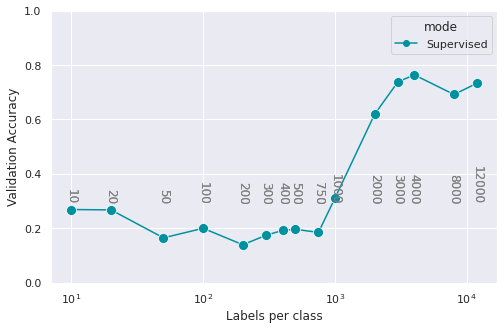

In [11]:
hereon_color_array_1 = np.array([
    [0,145,160],
     
    [0, 170, 230],
    [250,180,35],
    [0,70,125],
    [175, 25, 60],
    [170, 200 ,70],
    [250,115,80],
    [140, 90, 180],
      
])
hereon_color_array = hereon_color_array / 255
hereon_cmap = ListedColormap(hereon_color_array)
# df = df[df["Labels per class"] <= 3500]  # do not use all runs, because not all is finished yet!
df_grouped2 = df_grouped.reset_index()[df_grouped.reset_index()["mode"] == "Supervised"]
fig, ax = plt.subplots(figsize=(8,5), nrows=1, ncols=1)
sns.lineplot(data=df_grouped2, x="Labels per class", y="Validation Accuracy", hue="mode", ax=ax, markers=True, style="mode", markersize=10, palette=hereon_color_array_1)
# autosize()
ax.set_xscale("log")
ax.set_ylim(0,1)

for item in df_grouped.groupby("Labels per class"):
    #item[1] is a grouped data frame
    for x,y,m in item[1].reset_index()[["Labels per class","Validation Accuracy","Labels per class"]].values:
        ax.text(x,0.3,f'{m:.0f}',color="grey", horizontalalignment="center", rotation=-90)

plt.savefig("supervised.png", dpi=600)
plt.show()

In [38]:
df_grouped

metric                      level_0 level_1  Accuracy/Training  \
Labels per class mode                                            
10               SimCLR       value  argmax           5.000000   
                 Supervised   value  argmax           4.000000   
20               SimCLR       value  argmax          10.000000   
                 Supervised   value  argmax          16.000000   
50               SimCLR       value  argmax          25.000000   
                 Supervised   value  argmax          28.000000   
100              SimCLR       value  argmax          26.000000   
                 Supervised   value  argmax          37.000000   
200              SimCLR       value  argmax          78.000000   
                 Supervised   value  argmax          75.000000   
300              SimCLR       value  argmax         123.000000   
                 Supervised   value  argmax         157.000000   
400              SimCLR       value  argmax          79.000000   
                 Supervised   value  argmax         175.000000   
500              SimCLR       value  argmax         137.000000   
                 Supervised   value     max           0.315789   
750              SimCLR       value  argmax         261.000000   
                 Supervised   value  argmax         383.000000   
1000             SimCLR       value  argmax         205.000000   
                 Supervised   value  argmax         548.000000   
2000             SimCLR       value  argmax         219.000000   
                 Supervised   value  argmax        1095.000000   
3000             SimCLR       value  argmax         297.000000   
                 Supervised   value  argmax        1759.000000   
4000             SimCLR       value  argmax         328.000000   
                 Supervised   value  argmax        2059.000000   
8000             SimCLR       value  argmax         278.000000   
                 Supervised   value  argmax        1179.000000   
12000            SimCLR       value  argmax         233.000000   
                 Supervised   value     max         627.000000   

metric                       Accuracy/Validation  Cosine LR   epoch  \
Labels per class mode                                                 
10               SimCLR                 0.450964       0.00   108.0   
                 Supervised             0.268511       0.00   108.0   
20               SimCLR                 0.547639       0.00   118.0   
                 Supervised             0.267114       0.00   118.0   
50               SimCLR                 0.637399       0.00   128.0   
                 Supervised             0.164292       0.00   128.0   
100              SimCLR                 0.708229       0.00   158.0   
                 Supervised             0.199497       0.00   158.0   
200              SimCLR                 0.736239       0.00   217.0   
                 Supervised             0.138866       0.00   217.0   
300              SimCLR                 0.752165       0.00   277.0   
                 Supervised             0.173792       0.00   277.0   
400              SimCLR                 0.761945       0.00   336.0   
                 Supervised             0.191674       0.00   336.0   
500              SimCLR                 0.766695       0.00   396.0   
                 Supervised             0.195585       0.02    99.0   
750              SimCLR                 0.781503       0.00   534.0   
                 Supervised             0.184409       0.00   534.0   
1000             SimCLR                 0.797429       0.00   683.0   
                 Supervised             0.310422       0.00   683.0   
2000             SimCLR                 0.804973       0.00  1267.0   
                 Supervised             0.618888       0.00  1267.0   
3000             SimCLR                 0.810841       0.00  1841.0   
                 Supervised             0.737916       0.00  1841.0   
4000             SimCLR                 0

In [13]:
with open("result_paths.txt", "w") as f:
    for _id, row in df_grouped.iterrows():
        f.write(row["run_path"])
        f.write("\n")

# Now run it on test data

In [14]:
import pytorch_lightning as pl
import onnxruntime as ort
import scipy.special
from PIL import Image
import sys
sys.path.append("..")
import sklearn.metrics
from src.datamodule.DataLoader import PlanktonDataLoader
import hydra
from src.lib.config import Config, register_configs
from src.utils.utils import print_config
register_configs()
try:
    hydra.initialize(config_path="../conf", job_name="plankton")
except ValueError:
    print(ValueError)

In [15]:
pl.seed_everything(7)
np.random.seed(7)
cfg = hydra.compose(config_name="config", overrides=["+experiment=plankton/klas_supervised", "random_seed=7", "strategy=SingleDevice"])

Global seed set to 7


In [26]:
train_transforms = hydra.utils.instantiate(cfg.datamodule.train_transforms)
valid_transforms = hydra.utils.instantiate(cfg.datamodule.valid_transforms)

datamodule = hydra.utils.instantiate(
    cfg.datamodule,
    train_transforms=train_transforms,
    valid_transforms=valid_transforms,
    dataset=cfg.datamodule.dataset,
    is_ddp=False,
)
datamodule.setup()
dataloader = datamodule.test_dataloader()
val_dataloader = datamodule.val_dataloader()

In [17]:
if not "options" in locals():
    options = ort.SessionOptions()
    options.inter_op_num_threads = 1
    options.intra_op_num_threads = 2

In [31]:
if not "Test Accuracy" in df_grouped.columns:
    df_grouped = df_grouped.assign(acc_test=-777.0)
    df_grouped= df_grouped.rename(columns={"acc_test": "Test Accuracy"})
    
    df_grouped = df_grouped.assign(acc_val=-777.0)
    df_grouped= df_grouped.rename(columns={"acc_val": "Validation Accuracy rerun"})
    
for _id, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(row["run_path"], f"logs/checkpoints/model_*.onnx")
    all_onnx_files = glob.glob(file_path)
    
    ONNX_FILE = all_onnx_files[int(row["hp/epoch"]) -2]

    ort_sess = ort.InferenceSession(ONNX_FILE, sess_options=options, providers=["CUDAExecutionProvider"])
    ort_sess.get_inputs()[0].name

    # make some prediction from the loaded onnx model:

    input_name = ort_sess.get_inputs()[0].name
    output_name = ort_sess.get_outputs()[0].name

    predicted_probabilities = np.empty(shape=(len(dataloader.dataset), ort_sess.get_outputs()[0].shape[1]))
    targets = np.empty(shape=(len(dataloader.dataset), 1))
    predicted_labels = np.empty_like(targets)
    
    predicted_probabilities_val = np.empty(shape=(len(val_dataloader.dataset), ort_sess.get_outputs()[0].shape[1]))
    targets_val = np.empty(shape=(len(val_dataloader.dataset), 1))
    predicted_labels_val = np.empty_like(targets_val)
    counter = 0
    for batch in dataloader:
        x, y = batch
        predicted_probabilities[counter : counter + x.shape[0]] = ort_sess.run([output_name], {input_name: x.cpu().numpy()})[0]
        predicted_labels = scipy.special.softmax(predicted_probabilities, axis=1).argmax(axis=1)
        targets[counter : counter + x.shape[0]] = y[0]
        counter += x.shape[0]
    
    test_acc = sklearn.metrics.accuracy_score(y_true=targets, y_pred=predicted_labels)
    df_grouped.loc[row["Labels per class"]].at[row["mode"], "Test Accuracy"]  = test_acc
    
    counter = 0
    for batch in val_dataloader:
        x, y = batch
        predicted_probabilities_val[counter : counter + x.shape[0]] = ort_sess.run([output_name], {input_name: x.cpu().numpy()})[0]
        predicted_labels_val = scipy.special.softmax(predicted_probabilities_val, axis=1).argmax(axis=1)
        targets_val[counter : counter + x.shape[0]] = y[0]
        counter += x.shape[0]
        
    val_acc = sklearn.metrics.accuracy_score(y_true=targets_val, y_pred=predicted_labels_val)
    df_grouped.loc[row["Labels per class"]].at[row["mode"], "Validation Accuracy rerun"]  = val_acc
    
#     print(f'{row["mode"]} with {row["Labels per class"]} labels:')
#     print(test_acc)
#     print("=================")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [03:31<00:00,  6.21s/it]


In [35]:
# df_grouped

/gpfs/home/machnitz/miniconda3/envs/hydra/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


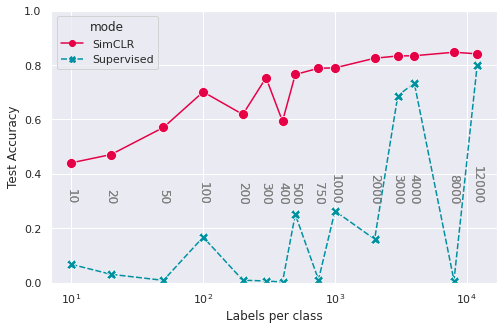

In [36]:
# df = df[df["Labels per class"] <= 3500]  # do not use all runs, because not all is finished yet!
fig, ax = plt.subplots(figsize=(8,5), nrows=1, ncols=1)
sns.lineplot(data=df_grouped, x="Labels per class", y="Test Accuracy", hue="mode", ax=ax, markers=True, style="mode", markersize=10, palette=hereon_color_array)
# autosize()
ax.set_xscale("log")

ax.set_ylim(0,1)

for item in df_grouped.groupby("Labels per class"):
    #item[1] is a grouped data frame
    for x,y,m in item[1].reset_index()[["Labels per class","Test Accuracy","Labels per class"]].values:
        ax.text(x,0.3,f'{m:.0f}',color="grey", horizontalalignment="center", rotation=-90)

plt.savefig("simclr_vs_supervised_test.png", dpi=600)
plt.show()

/gpfs/home/machnitz/miniconda3/envs/hydra/lib/python3.8/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


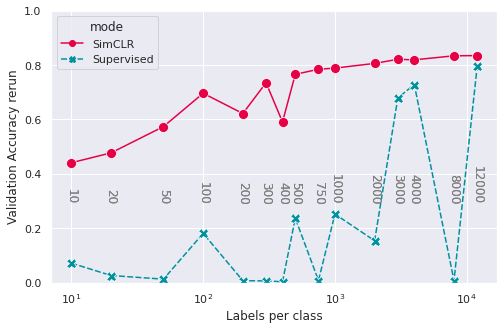

In [37]:
# df = df[df["Labels per class"] <= 3500]  # do not use all runs, because not all is finished yet!
fig, ax = plt.subplots(figsize=(8,5), nrows=1, ncols=1)
sns.lineplot(data=df_grouped, x="Labels per class", y="Validation Accuracy rerun", hue="mode", ax=ax, markers=True, style="mode", markersize=10, palette=hereon_color_array)
# autosize()
ax.set_xscale("log")

ax.set_ylim(0,1)

for item in df_grouped.groupby("Labels per class"):
    #item[1] is a grouped data frame
    for x,y,m in item[1].reset_index()[["Labels per class","Validation Accuracy rerun","Labels per class"]].values:
        ax.text(x,0.3,f'{m:.0f}',color="grey", horizontalalignment="center", rotation=-90)

plt.savefig("simclr_vs_supervised_valid_rerun.png", dpi=600)
plt.show()